In [15]:
import basedosdados as bd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

if os.environ.get('USERNAME') == "natha":

    dropbox_path = "C:/Users/natha/Dropbox/MiDES-data-paper-replication"
    github_path = "C:/Users/natha/OneDrive/Documentos/Github/data-paper"

elif os.environ.get('USER') == "nathaliasales":

    dropbox_path = "/Users/nathaliasales/Documents/MiDES-data-paper-replication"
    github_path = "/Users/nathaliasales/Documents/Github/data-paper"
    
elif os.environ.get('USERNAME') == "lucas":

    dropbox_path = ""
    github_path = ""

elif os.environ.get('USER') == "rdahis":

    dropbox_path = "/Users/rdahis/Dropbox/Academic/Papers/MiDES-data-paper-replication/"
    github_path  = "/Users/rdahis/Dropbox/Academic/Papers/MiDES-data-paper-repository"
    
input_path = os.path.join(dropbox_path, 'Data/Raw')
fig_output = os.path.join(dropbox_path, 'Output/Figures')
tab_output = os.path.join(dropbox_path, 'Output/Tables')

# Queries config
project_id_bq = os.environ.get('project_id_bq')
run_query = os.environ.get('run_query')

In [ ]:
# Query to generate the data for graphs

def run_query_and_save_results():

    query = '''
    
    SELECT
        a.*, l.modalidade, b.data, b.cnpj, b.id_municipio, b.data_inicio_atividade,
        b.sigla_uf, b.cnpj_basico, b.identificador_matriz_filial, s.opcao_simples, s.opcao_mei
    FROM (
        SELECT *
        FROM `basedosdados.world_wb_mides.licitacao_participante`
        WHERE id_licitacao_bd IS NOT NULL
      ) a
    LEFT JOIN (
        SELECT modalidade, id_licitacao_bd
        FROM `basedosdados.world_wb_mides.licitacao`
        WHERE id_licitacao_bd IS NOT NULL
      ) l
    ON a.id_licitacao_bd = l.id_licitacao_bd
    LEFT JOIN (
        SELECT
            CAST(cnpj AS STRING) AS cnpj,
            cnpj_basico,
            id_municipio,
            sigla_uf,
            identificador_matriz_filial,
            data_inicio_atividade,
            MAX(data) AS data
        FROM
            `basedosdados.br_me_cnpj.estabelecimentos`
        GROUP BY
            cnpj,
            cnpj_basico,
            id_municipio,
            sigla_uf,
            data_inicio_atividade,
            identificador_matriz_filial
    ) b ON CAST(a.documento AS STRING) = b.cnpj
    LEFT JOIN
        `basedosdados.br_me_cnpj.simples` s ON b.cnpj_basico = s.cnpj_basico
    WHERE
        a.tipo = '1'
        
    '''

    participante_cnpj = bd.read_sql(query, billing_project_id=project_id_bq)

    participante_cnpj.to_csv(os.path.join(input_path,'participante_cnpj.csv'), index=False, na_rep='', float_format='%.2f')

if __name__ == '__main__':
    if run_query == 'True':
        run_query_and_save_results()

In [22]:
# Open

participante_cnpj = pd.read_csv(os.path.join(input_path,'participante_cnpj.csv'), dtype=str)
population = pd.read_csv(os.path.join(input_path,'population.csv'), dtype=str)

# Find participants in same municipality

conditions = [
    (participante_cnpj['id_municipio'] == participante_cnpj['id_municipio_1']),
    (participante_cnpj['id_municipio'] != participante_cnpj['id_municipio_1']),
    (participante_cnpj['id_municipio_1'].isna())]

categories = [1,0, np.nan]
participante_cnpj['same_municipality'] = np.select(conditions, categories)

participante_cnpj['same_municipality']= pd.to_numeric(participante_cnpj['same_municipality'], errors='coerce')

# Find participants in same state

conditions = [
    (participante_cnpj['sigla_uf'] == participante_cnpj['sigla_uf_1']),
    (participante_cnpj['sigla_uf'] != participante_cnpj['sigla_uf_1']),
    (participante_cnpj['cnpj'].isna())]

categories = [1,0, np.nan]
participante_cnpj['same_state'] = np.select(conditions, categories)

participante_cnpj['same_state']= pd.to_numeric(participante_cnpj['same_state'], errors='coerce')

# Calculate firms' age

participante_cnpj['ano_inicio_atividade'] = participante_cnpj['data_inicio_atividade'].astype(str).str[:4]

participante_cnpj['ano_inicio_atividade'] = participante_cnpj['ano_inicio_atividade'].str.replace('NaT','-100')

participante_cnpj['idade_firma'] = np.where(participante_cnpj['ano_inicio_atividade']=='-100', np.nan,
                                            participante_cnpj['ano'].astype(int)-pd.to_numeric(participante_cnpj['ano_inicio_atividade'], errors='coerce'))

# Identify non-competitive tenders

participante_cnpj['licitacao_discricionaria'] = np.where((participante_cnpj['modalidade'] =="8") |(participante_cnpj['modalidade'] =="10"), 1, 0)

# Identify SMEs

participante_cnpj['firma_sme'] = np.where((participante_cnpj['opcao_simples']=="1") | (participante_cnpj['opcao_mei']=="1"), 1,0)

# Identify duplicated
#print(participante_cnpj.duplicated(subset=['id_licitacao_bd','cnpj']).value_counts(normalize=True)*100)

# Investigate duplicated origin
# Diferences in matriz_filial - few cases
#print(participante_cnpj.duplicated(subset=['id_licitacao_bd','cnpj','identificador_matriz_filial']).value_counts(normalize=True)*100)

# Investigate duplicated origin
# Firms in different municipalities over time - almost all cases
# Still 0.10% left - firms appearing 2 times in the same municipality, but with different data_inicio_atividade
#print(participante_cnpj.duplicated(subset=['id_licitacao_bd','cnpj','id_municipio_1']).value_counts(normalize=True)*100)

# Drop duplicated
# Keep first keeps the earliest dated observation. The oldest date on the panel is 2021, so no problem here.
participante_cnpj = participante_cnpj.drop_duplicates(subset=['id_licitacao_bd','cnpj'], keep='first')

# Select years available for all states

participante_cnpj['ano'] = participante_cnpj['ano'].astype(int)
participante_cnpj = participante_cnpj.query('ano > = 2014')

# Format

participante_cnpj['vencedor'] = participante_cnpj['vencedor'].astype(int)
participante_cnpj['same_municipality'] = participante_cnpj['same_municipality'].astype(float)
participante_cnpj['same_state'] = participante_cnpj['same_state'].astype(float)
participante_cnpj['idade_firma'] = participante_cnpj['idade_firma'].astype(float)
population['populacao'] = population['populacao'].astype(float)

# Home bias by state and by competition

home_bias = participante_cnpj.groupby(['id_municipio','sigla_uf', 'ano', 'vencedor'])[['same_municipality','same_state']].mean().reset_index()
home_bias.to_csv(os.path.join(input_path,'home_bias.csv'), index=False)

home_bias_avg = participante_cnpj.groupby(['id_municipio','sigla_uf','vencedor'])[['same_municipality','same_state']].mean().reset_index()
home_bias_competition = participante_cnpj.groupby(['id_municipio','sigla_uf','vencedor','licitacao_discricionaria'])[['same_municipality','same_state']].mean().reset_index()

# Home bias - population below and above mean

population['median_pop'] = population.groupby('ano')['populacao'].transform('median')

# Choose 2018 for proxy population
population['ano'] = population['ano'].astype(int)
population = population.query('ano==2018')
population.drop(['ano','sigla_uf'], axis=1, inplace=True)

home_bias_pop = pd.merge(home_bias_avg, population, how='left', left_on=['id_municipio'], right_on=['id_municipio'])
home_bias_pop['pop_above_median'] = np.where(home_bias_pop['populacao'] > home_bias_pop['median_pop'], 1,0)

In [20]:
home_bias.to_csv(os.path.join(input_path,'home_bias.csv'), index=False)

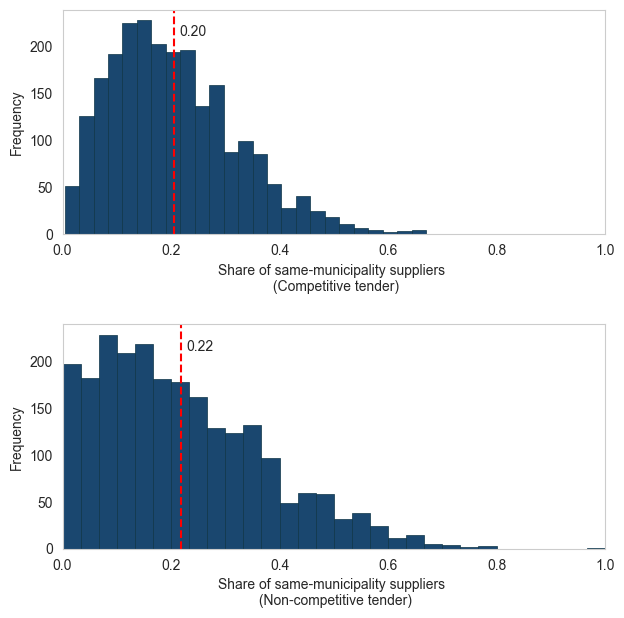

In [23]:
# Home bias by competition

# Style
sns.set_style('whitegrid')

fig, axs = plt.subplots(2, 1, figsize=(7, 7))

fig.subplots_adjust(hspace=0.4)

# Winners
vencedores1 = home_bias_competition.query('vencedor==1 & licitacao_discricionaria==0')
vencedores2 = home_bias_competition.query('vencedor==1 & licitacao_discricionaria==1')

# Same municipality winners - competitive tenders
axs[0].hist(vencedores1['same_municipality'], bins=25, facecolor='#1A476F', edgecolor='#0D3446', linewidth=0.5)
axs[0].set_xlabel('Share of same-municipality suppliers \n (Competitive tender)', fontsize=10)
axs[0].set_ylabel('Frequency', fontsize=10)

# Same municipality winners - non-competitive tenders
axs[1].hist(vencedores2['same_municipality'], bins=30, facecolor='#1A476F', edgecolor='#0D3446', linewidth=0.5)
axs[1].set_xlabel('Share of same-municipality suppliers \n (Non-competitive tender)', fontsize=10)
axs[1].set_ylabel('Frequency', fontsize=10)

# Add mean
media_vencedores1 = vencedores1['same_municipality'].mean()
media_vencedores2 = vencedores2['same_municipality'].mean()

axs[0].axvline(x=media_vencedores1, color='r', linestyle='--')
axs[0].text(media_vencedores1 + 0.01, axs[0].get_ylim()[1]*0.9, f'{media_vencedores1:.2f}', ha='left', va='center')

axs[1].axvline(x=media_vencedores2, color='r', linestyle='--')
axs[1].text(media_vencedores2 + 0.01, axs[1].get_ylim()[1]*0.9, f'{media_vencedores2:.2f}', ha='left', va='center')

# Limits
for ax in axs:
  ax.set_xlim([0, 1.0])

# Drop grids
for ax in axs:
    ax.grid(False)

plt.savefig(os.path.join(fig_output, 'home_bias_all.pdf'), bbox_inches='tight')

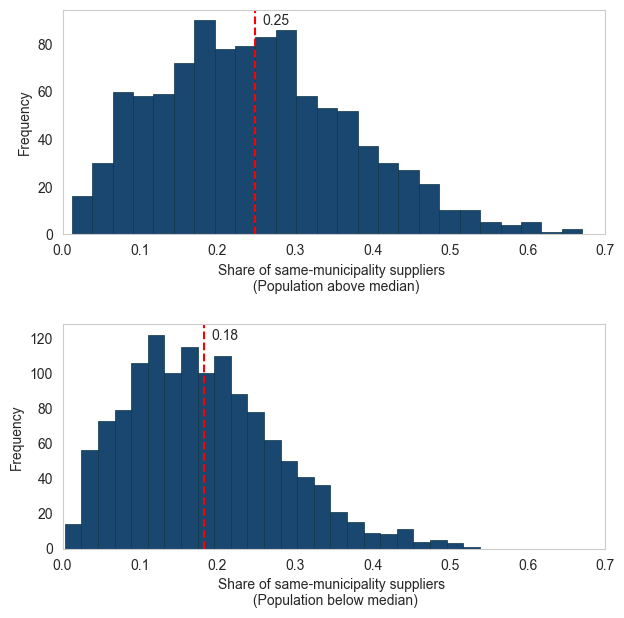

In [25]:
# Home bias - population below and above median

# Style
sns.set_style('whitegrid')

fig, axs = plt.subplots(2, 1, figsize=(7, 7))

fig.subplots_adjust(hspace=0.4)

# Winners
vencedores1 = home_bias_pop.query('vencedor==1 & pop_above_median==1')
vencedores2 = home_bias_pop.query('vencedor==1 & pop_above_median==0')

# Same municipality winners - competitive tenders
axs[0].hist(vencedores1['same_municipality'], bins=25, facecolor='#1A476F', edgecolor='#0D3446', linewidth=0.5)
axs[0].set_xlabel('Share of same-municipality suppliers \n (Population above median)', fontsize=10)
axs[0].set_ylabel('Frequency', fontsize=10)

# Same municipality winners - non-competitive tenders
axs[1].hist(vencedores2['same_municipality'], bins=25, facecolor='#1A476F', edgecolor='#0D3446', linewidth=0.5)
axs[1].set_xlabel('Share of same-municipality suppliers \n (Population below median)', fontsize=10)
axs[1].set_ylabel('Frequency', fontsize=10)

# Add mean
media_vencedores1 = vencedores1['same_municipality'].mean()
media_vencedores2 = vencedores2['same_municipality'].mean()

axs[0].axvline(x=media_vencedores1, color='r', linestyle='--')
axs[0].text(media_vencedores1 + 0.01, axs[0].get_ylim()[1]*0.95, f'{media_vencedores1:.2f}', ha='left', va='center')

axs[1].axvline(x=media_vencedores2, color='r', linestyle='--')
axs[1].text(media_vencedores2 + 0.01, axs[1].get_ylim()[1]*0.95, f'{media_vencedores2:.2f}', ha='left', va='center')

# Limits
for ax in axs:
  ax.set_xlim([0, 0.7])

# Drop grids
for ax in axs:
    ax.grid(False)

plt.savefig(os.path.join(fig_output,'home_bias_population.pdf'), bbox_inches='tight')

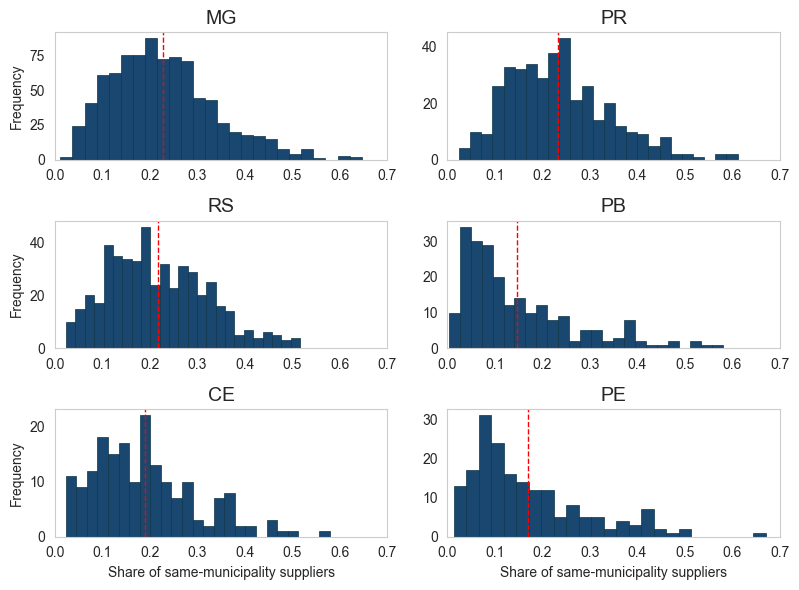

In [24]:
# Home bias by state

# Style
sns.set_style('whitegrid')

# List UFs
ufs = ['MG', 'PR', 'RS', 'PB', 'CE', 'PE']

vencedores_ufs = home_bias_avg.query('vencedor==1 and sigla_uf in @ufs')

# Subplot for each UF
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 6))

xlim = [0, 0.7]

# Iteranting for each UF
for i, uf in enumerate(ufs):
    # Position of subplot
    row = i // 2
    col = i % 2

    # Filter
    filtro = vencedores_ufs.query('sigla_uf == @uf')

    # Plot histogram for same_municipality
    axs[row, col].hist(filtro['same_municipality'], bins=25, facecolor='#1A476F', edgecolor='#0D3446', linewidth=0.5)

    # Configuring x-axis label for the last two plots
    if row >= 2:
        axs[row, col].set_xlabel('Share of same-municipality suppliers', fontsize=10)

    if col == 0:
      axs[row, col].set_ylabel('Frequency', fontsize=10)

    axs[row, col].set_title(f'{uf}', fontsize=14)
    axs[row, col].set_xlim(xlim)

    # Add mean
    media = filtro['same_municipality'].mean()
    axs[row, col].axvline(x=media, color='red', linestyle='--', linewidth=1)

    axs[row, col].grid(False)

# Layout
fig.tight_layout(w_pad=2.5)

plt.savefig(os.path.join(fig_output,'home_bias_by_state.pdf'), bbox_inches='tight')